In [2]:
 #!pip install opencv_contrib_python==3.4.2.17 --force-reinstall

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv

# Verify OpenCV version
print(cv.__version__)

3.4.2


In [3]:
#questo comando è utile per visualizzare le immagini con una certa dimensione (per pyplot), altrimenti verrebbero troppo piccole
plt.rcParams['figure.figsize'] = [15, 5] # width, height

In [4]:
# Image loading
im2 = cv.imread('parete1.jpeg',0)
im1 = cv.imread('parete2.jpeg',0)

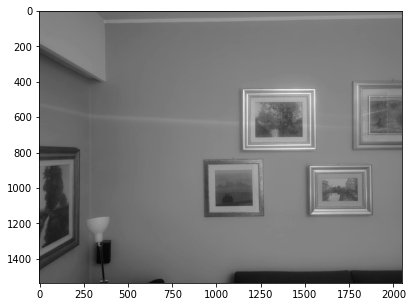

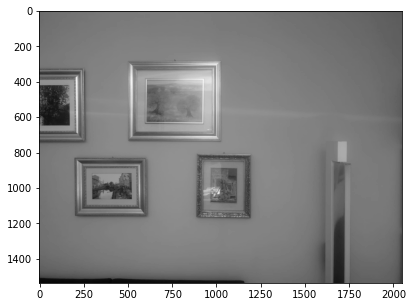

In [5]:
plt.imshow(im1, cmap='gray'); plt.show()
plt.imshow(im2, cmap='gray'); plt.show()

# Photo stitching
Image stitching is a method by which multiple photographic images are combined.  
The stitching process can be divided into three main steps: image acquisition, calibration and editing.  
 

1.   **Acquisition**  
Image acquisition involves a series of functions that use feature detection to search for alignments between images to reduce differences in pixel overlap.
2.   **Calibration**  
Image calibration helps to reduce differences in distortion, exposure, vignetting, and chromatic aberration caused by the lens used in the camera.
3.   **Mounting**  
Mounting images involves making the adjustments made in the calibration step, combined with remapping the images to obtain an output.






In [18]:
sift = cv.xfeatures2d.SIFT_create()
kps1, features1 = sift.detectAndCompute(im1, None)
kps2, features2 = sift.detectAndCompute(im2, None)

In [19]:
print("Keypoints first image:", len(kps1))
print("keypoints second image:", len(kps2))

Keypoints first image: 1076
keypoints second image: 1954


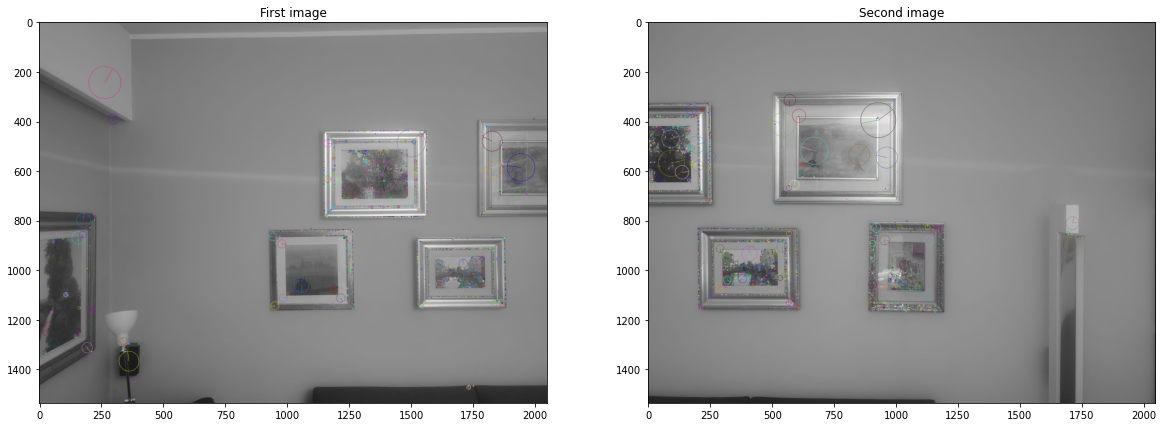

In [20]:
# SIFT points visualization
box_kps_1 = cv.drawKeypoints(im1, kps1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
box_kps_2 = cv.drawKeypoints(im2, kps2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig = plt.figure(figsize=(20,10))

fig.add_subplot(1,2,1)
plt.imshow(box_kps_1, cmap='gray')
plt.title('First image')

fig.add_subplot(1,2,2)
plt.imshow(box_kps_2, cmap='gray')
plt.title('Second image')

plt.show()

As you might expect most of the features are identified in the details of the paintings hanging on the wall

In [21]:
# Keypoints extraction
sift = cv.xfeatures2d.SIFT_create()
(kps1, features1) = sift.detectAndCompute(im1, None)
(kps2, features2) = sift.detectAndCompute(im2, None)
# Features matching
bf = cv.BFMatcher(crossCheck=True)
matches = bf.match(features1, features2)

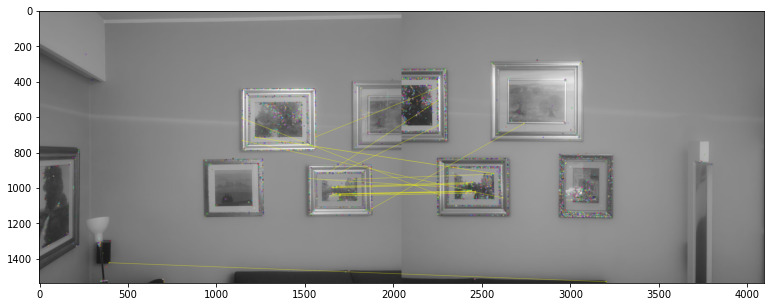

In [22]:
# Display best 20 matches
matches = sorted(matches, key=lambda x:x.distance)
result = cv.drawMatches(im1, kps1, im2, kps2, matches[0:20], None, matchColor=[255,255,0])
plt.imshow(result)
plt.show()

#### **1. Find the homography which describes the transformation from the second set of points to the first one**
https://docs.opencv.org/3.4.2/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780  
What is the homography matrix?  
Briefly, the planar homography relates the transformation between two planes (up to a scale factor):  
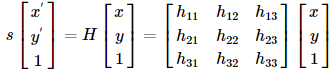

The homography matrix is a 3x3 matrix but with 8 DoF (degrees of freedom) as it is estimated up to a scale. It is generally normalized (see also 1) with:  
image.png

In [23]:
def myHomography(kps1, kps2, matches):
  matches = sorted(matches, key=lambda x:x.distance)
  source_pts = np.asarray([kps1[m.queryIdx].pt for m in matches])
  destination_pts = np.asarray([kps2[m.trainIdx].pt for m in matches])
  H,_ = cv.findHomography(destination_pts, source_pts, cv.RANSAC, ransacReprojThreshold=5)
  return H

The RANSAC technique used to calculate homography is useful in eliminating false positives

In [24]:
H = myHomography(kps1, kps2, matches)
print(H)

[[ 8.61301207e-01 -3.28298271e-02  1.33227042e+03]
 [-1.04735449e-02  8.36762931e-01  1.60790310e+02]
 [-6.13330686e-06 -2.17902343e-05  1.00000000e+00]]


#### 2. Apply the homography to the second image
https://docs.opencv.org/3.4.2/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87  
https://docs.opencv.org/3.4.2/da/d6e/tutorial_py_geometric_transformations.html

In [25]:
def mywrap(im1, im2, H):
    return cv.warpPerspective(im2, H, (im1.shape[1] + im2.shape[1], im1.shape[0]))

Applies a perspective transformation to an image.

The function warpPerspective transforms the source image using the specified matrix:
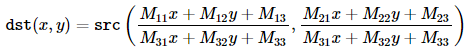

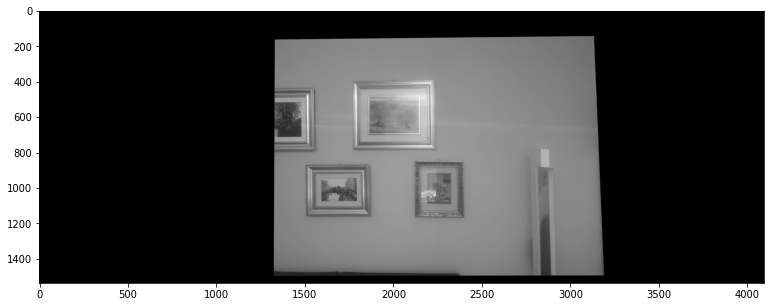

In [26]:
# Apply a perspective warp to stitch the images together
temp= mywrap(im1, im2, H)
plt.imshow(temp, cmap = "gray"); plt.show()

#### **3. Integrate the first image**


In [ ]:
# temp[from_y:to_y, from_x:to_x] = im_new

In [27]:
def myCollage(im_base, im_new):
  im_base[0:im1.shape[0], 0:im1.shape[1]] = im_new
  return im_base

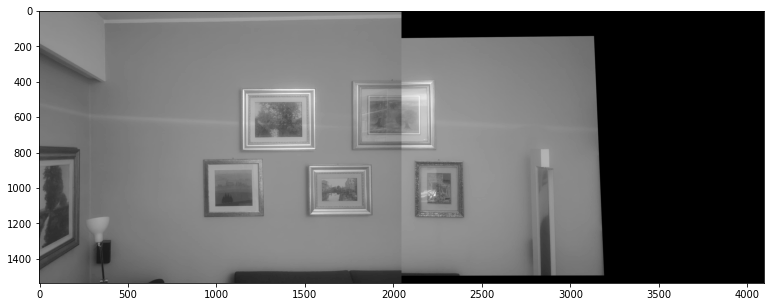

In [28]:
result = myCollage(temp, im1)
plt.imshow(result, cmap='gray'); plt.show()

I got a good result that could be improved by adjusting the size of the image on the right and adjust the brightness of one of the 2 images